In [1]:
%matplotlib inline
import seaborn as sns
import pymc3 as pm
import numpy as np
from numpy import random as nr

In [2]:
# DirichletMultinomial model
import theano.tensor as tt
from pymc3.distributions.dist_math import gammaln, bound, factln
class DirichletMultinomial(pm.Discrete):
    def __init__(self, n, a, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)

        self.K = tt.as_tensor_variable(a.shape[-1])
        self.n = tt.as_tensor_variable(n[:, np.newaxis])

        if a.ndim == 1:
            self.alphas = tt.as_tensor_variable(a[np.newaxis, :])  # alphas[1, #classes]
        else:
            self.alphas = tt.as_tensor_variable(a)  # alphas[#samples, #classes]

        self.A = self.alphas.sum(axis=-1, keepdims=True)  # A[#samples]
        self.mean = self.n * (self.alphas / self.A)

        self.mode = tt.cast(pm.math.tround(self.mean), 'int32')

    def logp(self, value):
        printing = False
        k = self.K
        a = self.alphas
        A = self.A
        n = self.n
        res = bound(tt.squeeze(factln(n) + gammaln(A) - gammaln(A + n) +
                               tt.sum(gammaln(a + value) - gammaln(a) - factln(value), keepdims=True, axis=-1)),
                    tt.all(value >= 0),
                    tt.all(tt.eq(tt.sum(value, axis=-1, keepdims=True), n)),
                    tt.all(a > 0),
                    k > 1,
                    tt.all(tt.ge(n, 0)),
                    broadcast_conditions=False
                    )
        return res
    

### Generate simple data (n constant)

In [43]:
N = 200
#D = 4
d1 = np.array([5, 7, 1, 0.5])
d2 = np.array([8, 12, 5, 10])

alphas = np.concatenate([np.repeat(d1[np.newaxis, :], N/2, axis=0), np.repeat(d2[np.newaxis, :], N/2, axis=0)])
print(alphas.shape)
#ndraws = 2000
#data_alpha = 1
#data_beta = 1/2
ndraws = np.random.randint(1, 1000, size=N)
#alphas = nr.gamma(data_alpha, 1/data_beta, size=(N, D))

dirichlets = np.array([nr.dirichlet(alpha) for alpha in alphas])
data = np.array([nr.multinomial(n, p) for p, n in zip(dirichlets, ndraws)])
#data = np.array([nr.multinomial(ndraws, p) for p in dirichlets])

(200, 4)


### Test explicit model

(1, 4)
(100, 4)
(200, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 2,741.7:  12%|█▏        | 24556/200000 [00:22<02:31, 1154.94it/s]
Convergence archived at 24600
Interrupted at 24,600 [12%]: Average Loss = 6,946.9
100%|█████████▉| 1797/1800 [00:33<00:00, 64.81it/s]/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 19 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1800/1800 [00:33<00:00, 53.47it/s]



alphas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  5.777            0.590            0.022            [4.653, 6.962]
  7.728            0.781            0.031            [6.047, 9.120]
  1.057            0.112            0.004            [0.846, 1.272]
  0.514            0.060            0.002            [0.397, 0.633]
  ..............................[1, :]...............................
  8.122            0.751            0.032            [6.848, 9.688]
  12.476           1.163            0.050            [10.270, 14.836]
  5.227            0.500            0.020            [4.418, 6.363]
  10.142           0.935            0.041            [8.286, 11.976]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  ......

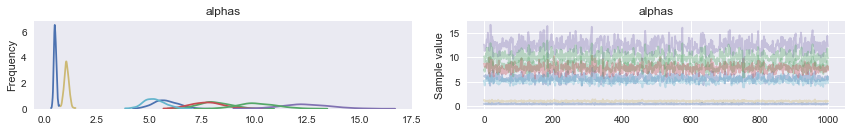

In [55]:
with pm.Model() as model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('alphas', shape=(2, int(alphas.shape[1])))
    a1padded = tt.shape_padleft(a[0])
    a2padded = tt.shape_padleft(a[1])
    print(a1padded.tag.test_value.shape)
    d1s = tt.repeat(a1padded, int(N/2), axis=0)
    d2s = tt.repeat(a2padded, int(N/2), axis=0)
    print(d1s.tag.test_value.shape)
    aconcat = tt.concatenate([d1s, d2s], axis=0)
    print(aconcat.tag.test_value.shape)
    d = pm.Dirichlet('dirichlets', aconcat, shape=(N, alphas.shape[1]))
    obs = pm.Multinomial('data', n=ndraws[:, np.newaxis], p=d, observed=data)

with model:
    #step = pm.Metropolis()
    trace = pm.sample(tune=800, draws=1000)
    pm.traceplot(trace, ['alphas'])
    pm.summary(trace, ['alphas'])

### Test implicit model

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


(1, 4)
(100, 4)
(200, 4)


Average Loss = 2,753.7:   7%|▋         | 14413/200000 [00:05<01:02, 2975.60it/s]
Convergence archived at 14600
Interrupted at 14,600 [7%]: Average Loss = 2,934.9
100%|██████████| 1800/1800 [00:13<00:00, 135.19it/s]



alphas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  5.762            0.573            0.021            [4.552, 6.828]
  7.731            0.785            0.030            [6.106, 9.142]
  1.052            0.110            0.004            [0.832, 1.255]
  0.515            0.060            0.002            [0.401, 0.630]
  ..............................[1, :]...............................
  8.167            0.791            0.036            [6.624, 9.703]
  12.536           1.175            0.054            [9.998, 14.543]
  5.253            0.521            0.023            [4.278, 6.303]
  10.166           0.964            0.040            [8.301, 11.994]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  .......

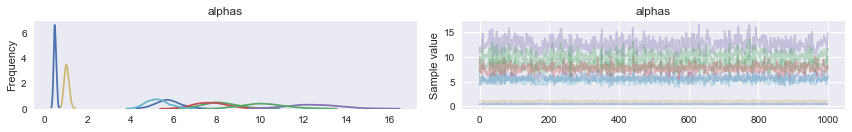

In [56]:
with pm.Model() as implicit_model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('alphas', shape=(2, int(alphas.shape[1])))
    a1padded = tt.shape_padleft(a[0])
    a2padded = tt.shape_padleft(a[1])
    print(a1padded.tag.test_value.shape)
    d1s = tt.repeat(a1padded, int(N/2), axis=0)
    d2s = tt.repeat(a2padded, int(N/2), axis=0)
    print(d1s.tag.test_value.shape)
    aconcat = tt.concatenate([d1s, d2s], axis=0)
    print(aconcat.tag.test_value.shape)
    n=ndraws#np.array([ndraws]*N)
    obs = DirichletMultinomial('data', n=n, a=aconcat, observed=data)

with implicit_model:
    #step=pm.Metropolis()
    implicit_trace = pm.sample(tune=800, draws=1000)
    pm.traceplot(implicit_trace, ['alphas'])
    pm.summary(implicit_trace, ['alphas'])